### Import all required packages

In [1]:
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy
import json
import os
import glob
import time
import datetime
from IPython.display import display                 # Allows the use of display() for DataFrames

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras import optimizers
from keras import regularizers

import multiprocessing as mp

from mpl_toolkits.mplot3d import Axes3D

# Pretty display for notebooks
%matplotlib inline                                  

/Users/Gio/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Gio/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using TensorFlow backend.


### Updateable Parameters

In [2]:
## Start time.  Used to measure execution time.
START = time.clock()

## Yahoo's API has changed, so we'll use google as our source
#DATA_SOURCE = 'google'
DATA_SOURCE = 'yahoo'

## Date range used for training data
#TRAINING_START_DATE = '2010-01-01'
#TRAINING_END_DATE = '2017-7-31'
TRAINING_START_DATE = datetime.datetime(2014, 4, 1)
TRAINING_END_DATE = datetime.datetime(2016, 5, 31)

## Date range used for testing data
#TEST_START_DATE = '2016-06-01'
#TEST_END_DATE = '2017-7-31'
TEST_START_DATE = datetime.datetime(2016, 6, 1)
TEST_END_DATE = datetime.datetime(2017, 7, 31)

# ## Stock tickers for training data
TRAINING_TICKERS = ['AAPL','GOOG','T','IMAX','IBM','NFLX','SIRI','S','PLUG','C',\
                   'ZNGA','WMS','BAC','AMZN','FB','P','WM','NOK','DDD','XME','XONE','SDRL',\
                   'TSLA','SSYS','TXN','F','GS','LQMT','HTZ','BAH','GLW','SPWR',\
                   'BIDU','SRPT','YGE','CNX','URRE','VJET','RAD','NQ',\
                   'KORS','TWTR','HLF','ORCL','WLL','BLDP','PEG','MJNA','CBIS',\
                   'TM','SBUX','MBLY','MRK','DBO','PFE','CAMP','TRXC',\
                   'BMY','FE','VTR','UHT','MVO','KF','RACE','STOR','MU','RTN']
# TRAINING_TICKERS = ['AAPL', 'GOOG', 'YHOO', 'T', 'IMAX', 'IBM', 'NFLX', 'SIRI', 'S', 'PLUG', \
#            'C', 'BAC', 'P', 'NOK', 'XONE', 'SSYS', 'TSLA', 'AMZN', 'SDRL', 'DDD', \
#            'DBO', 'SRPT', 'SPWR', 'SCTY', 'FB', 'URRE', 'NQ', 'TWTR', 'F', 'BAH', \
#            'MZDAY','FSYS', 'BIDU', 'KORS', 'HLF', 'ORCL', 'MBLY']
           ## SOME NETWORK CAUSES MZDAY AND FSYS TO HAVE SOME NaN FOR SOME REASON

## Stock tickers for testing data
## unable to read SHOP,HEMP,LMT
# TESTING_TICKERS = ['BA','OLED', 'HON','MA','TPLM', 'SD', 'FCEL', 'CHK', 'CMG','UHT','STOR',\
#                    'UHT','BMY','FE','VTR','UHT','MVO','KF','RACE','MU','RTN'] 
#TESTING_TICKERS = ['BA','OLED', 'HON','MA','TPLM', 'SD', 'FCEL', 'CHK', 'CMG']  
TESTING_TICKERS = ['BA', 'HON','MA','TPLM', 'SD', 'FCEL', 'CHK', 'CMG'] 
#TESTING_TICKERS = ['BA', 'HON','MA']
#TESTING_TICKERS = ['SD', 'FCEL', 'CHK', 'CMG']

## Initial money to be invested
MONEY = 10000

## Commision rate when buying/selling stocks
COMM_RATE = 4.95

## Long term capital gain tax rate (percentage)
GAIN_LONG = 0.15

## Short term capital gain tax rate (percentage).  
## Also used for losses, assuming its the individuals tax bracket
GAIN_SHORT = 0.25

## Models predict the ratio base on these targets
#TARGET_RATIOS = ['vr15','vr25','vr40']
TARGET_RATIOS = ['vClose','vr2','vr3','vr5','vr10','vr15','vr25','vr40']
## New target ratio, will not just be relative to close
#TARGET_RATIOS = ['Close_pc','r2_p2','r3_p3','r5_p5','r10_p10','r15_p15','r25_p25','r40_p40']

## Used to determine when predictions will be a buy/sell
#SELL_BUY_VALUES = [(1,1)]
SELL_BUY_VALUES = [(0.985,0.985),(0.99,0.99),(0.995,0.995), (1,1),(1.005,1.005),\
                   (1.01,1.01),(1.015,1.015), \
                   (0.985,1.015),(0.99,1.01),(0.995,1.005),\
                   (0.995,1.00),(1.00,1.005),(1.005,1.01), \
                   (1.00,1.015),(1.00,1.01)]

## Set to True if we are reading existing models
## Set to False to generate new models
READ_EXISTING_MODELS = True

## Set True if using multiprocessing
MULTIPROCESSOR = True

## Number of processes for multiprocessing pool
NUM_PROCESSES = 8

## Set True to read existing training stocks
## If training tickers have been updated, set this to False
READ_EXISTING_TRAINING_STOCKS = True

## Set True to read existing testing stocks
## If testing tickers have been updated, set this to False
READ_EXISTING_TESTING_STOCKS = True

### Get all the stocks data.  Save data as pickle files

In [3]:
def gather_training_data():
    all_weekdays = pd.date_range(start=TRAINING_START_DATE,end=TRAINING_END_DATE,freq='B')
    ## panel type
    panel_data = data.DataReader(TRAINING_TICKERS,DATA_SOURCE,TRAINING_START_DATE,\
                                 TRAINING_END_DATE) 
    
    if DATA_SOURCE == 'yahoo':
        ## Yahoo has extra column
        panel_data.drop('Adj Close', inplace=True)
    
    panel_data.drop('Volume', inplace=True)
    
    ## save to pickle
    panel_data.to_pickle('training_stocks.pkl')                                                      

def gather_testing_data():
    all_weekdays = pd.date_range(start=TEST_START_DATE,end=TEST_END_DATE,freq='B')
    panel_data = data.DataReader(TESTING_TICKERS,DATA_SOURCE,TEST_START_DATE,TEST_END_DATE) 
    
    if DATA_SOURCE == 'yahoo':
        ## Yahoo has extra column
        panel_data.drop('Adj Close', inplace=True)
    
    panel_data.drop('Volume', inplace=True)
    
    panel_data.to_pickle('testing_stocks.pkl')  
    
## Read existing data
if READ_EXISTING_TRAINING_STOCKS == False:
    gather_training_data()  
    
if READ_EXISTING_TESTING_STOCKS == False:
    gather_testing_data()   

### Helper function to get the rolling averages. 2, 3, 5, 10, 15, 25 and 40-day moving averages.

In [4]:
def get_rolling(df):
    stock = df['Close']
    r2 = stock.rolling(window=2).mean()
    r3 = stock.rolling(window=3).mean()
    r5 = stock.rolling(window=5).mean()
    r10 = stock.rolling(window=10).mean()
    r15 = stock.rolling(window=15).mean()
    r25 = stock.rolling(window=25).mean()
    r40 = stock.rolling(window=40).mean()

    return r2, r3, r5, r10, r15, r25, r40

### Helper function to plot stocks data, with rolling averages

In [5]:
def plot_stock(tick, df):
    print("Plotting: ", tick)
    close = df['vClose']
    r2 = df['vr2']
    r3 = df['vr3']
    r5 = df['vr5']
    r10 = df['vr10']
    r15 = df['vr15']
    r25 = df['vr25']
    r40 = df['vr40']

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(close.index,close,label=tick)
    ax.plot(r2.index, r2, label='2 days rolling')
    ax.plot(r3.index, r3, label='3 days rolling')
    ax.plot(r5.index, r5, label='5 days rolling')
    ax.plot(r10.index, r10, label='10 days rolling')
    ax.plot(r15.index, r15, label='15 days rolling')
    ax.plot(r25.index, r25, label='25 days rolling')
    ax.plot(r40.index, r40, label='40 days rolling')
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing prices ($)')
    ax.legend()

    #plt.show()
    #fig.savefig("figures/"+tick+'.png')
    fig.savefig("figures/"+tick+'.svg', format='svg', dpi=1200)
    plt.close(fig)

### Helper function to statistics of the training data

In [6]:
def describe_data():
    df = pd.DataFrame.from_csv("training_data/all_raw_data.csv")
    df = df.describe()
    df.to_csv("training_data/all_raw_data_description.csv") 
    print("\nRaw training data description:\n",df)
    
    df = pd.DataFrame.from_csv("training_data/all_processed_data.csv")
    df = df.describe()
    df.to_csv("training_data/all_processed_data_description.csv") 
    print("\nProcessed training data description:\n",df)
    

### Get each DataFrame of the entire list of stocks for training, from the pickle file

In [7]:
def get_training_stocks_df(filename):
    processed_df = pd.DataFrame()
    raw_inputs_df = pd.DataFrame()
    raws = []
    processed = []
    panel_data = pd.read_pickle(filename)                       ## read saved stocks data

    for tick in TRAINING_TICKERS:
        ## Extract single stock from panel_data
        df = panel_data[:,:,tick]                               ## becomes df type, from panel
        df.to_csv("training_data/"+tick+".csv")                 ## raw input
        
        raws.append(df)                                         ## gather all the raw input together
        
        ## Get full df with 109 columns
        df = get_stock_df(df,tick)
        
        ## Save df
        df.to_csv("training_data/"+tick+"_processed.csv") 
        
        ## Plot stock
        plot_stock(tick,df)
        
        #processed_df = processed_dfmain_df.append(df)                                     
        processed.append(df)                            ## faster to append once, with [] of df
        
    ## append all raw input to one df, then save   
    raw_inputs_df = raw_inputs_df.append(raws)
    raw_inputs_df.to_csv("training_data/all_raw_data.csv")
    
    ## append all processed input to on df, then save 
    processed_df = processed_df.append(processed)       ## faster to append once, with [] of df
    processed_df.to_csv("training_data/all_processed_data.csv")
        
    return processed_df

### Helper function to get DataFrame of individual stocks.  Generates 108 columns, 20 columns will be removed later

In [8]:
"""
Columns generated:

#predict, prev_close, prev_r2, prev_r3, prev_r5, prev_r10, prev_r15, prev_r25, prev_r40, Vol,
predict, prev_close, prev_r2, prev_r3, prev_r5, prev_r10, prev_r15, prev_r25, prev_r40,
vOpen, vHigh, vLow, vClose, vr2, vr3, vr5, vr10, vr15, vr25, vr40,
Open_pc, High_pc, Low_pc, Close_pc, r2_pc, r3_pc, r5_pc, r10_pc, r15_pc, r25_pc, r40_pc,
Open_p2, High_p2, Low_p2, Close_p2, r2_p2, r3_p2, r5_p2, r10_p2, r15_p2, r25_p2, r40_p2,
Open_p3, High_p3, Low_p3, Close_p3, r2_p3, r3_p3, r5_p3, r10_p3, r15_p3, r25_p3, r40_p3,
Open_p5, High_p5, Low_p5, Close_p5, r2_p5, r3_p5, r5_p5, r10_p5, r15_p5, r25_p5, r40_p5,
Open_p10, High_p10, Low_p10, Close_p10, r2_p10, r3_p10, r5_p10, r10_p10, r15_p10, r25_p10, r40_p10,
Open_p15, High_p15, Low_p15, Close_p15, r2_p15, r3_p15, r5_p15, r10_p15, r15_p15, r25_p15, r40_p15,
Open_p25, High_p25, Low_p25, Close_p25, r2_p25, r3_p25, r5_p25, r10_p25, r15_p25, r25_p25, r40_p25,
Open_p40, High_p40, Low_p40, Close_p40, r2_p40, r3_p40, r5_p40, r10_p40, r15_p40, r25_p40, r40_p40,

"""
def get_stock_df(df,tick):
    ## Yahoo and Google data source returns different orders, ## make sure its this order
    #df = df.reindex_axis(['Open','High','Low','Close','Volume'], axis=1)        
    df = df.reindex_axis(['Open','High','Low','Close'], axis=1) 
    
    r2, r3, r5, r10, r15, r25, r40 = get_rolling(df)        ## get moving averages

    ## Rename Volume column then remove it
#     vol = df['Volume']
#     vol = vol.to_frame()
#     vol.columns = ['Vol']
#     df = df.drop('Volume', 1)                               ## 1 for axis 1, which is column

    ## Rename columns
    df_r2= r2.to_frame()                                    ## from series to df
    df_r2.columns = ['r2']                                  ## change column title

    df_r3= r3.to_frame()
    df_r3.columns = ['r3']

    df_r5= r5.to_frame()
    df_r5.columns = ['r5']

    df_r10= r10.to_frame()                                                      
    df_r10.columns = ['r10']                                                    

    df_r15= r15.to_frame()
    df_r15.columns = ['r15']

    df_r25= r25.to_frame()
    df_r25.columns = ['r25']

    df_r40= r40.to_frame()
    df_r40.columns = ['r40']

    ## Shift rows to generate next/previous values
    #predict = df['Close'].copy()
    predict = df['Close'].shift(-1)                                          ## a series
    predict = predict.to_frame()
    predict.columns = ['predict']

    prev_close = df['Close'].shift(1)
    prev_close = prev_close.to_frame()
    prev_close.columns = ['prev_close']

    prev_r2 = df_r2['r2'].shift(1)
    prev_r2 = prev_r2.to_frame()
    prev_r2.columns = ['prev_r2']

    prev_r3 = df_r3['r3'].shift(1)
    prev_r3 = prev_r3.to_frame()
    prev_r3.columns = ['prev_r3']

    prev_r5 = df_r5['r5'].shift(1)
    prev_r5 = prev_r5.to_frame()
    prev_r5.columns = ['prev_r5']

    prev_r10 = df_r10['r10'].shift(1)
    prev_r10 = prev_r10.to_frame()
    prev_r10.columns = ['prev_r10']

    prev_r15 = df_r15['r15'].shift(1)
    prev_r15 = prev_r15.to_frame()
    prev_r15.columns = ['prev_r15']

    prev_r25 = df_r25['r25'].shift(1)
    prev_r25 = prev_r25.to_frame()
    prev_r25.columns = ['prev_r25']

    prev_r40 = df_r40['r40'].shift(1)
    prev_r40 = prev_r40.to_frame()
    prev_r40.columns = ['prev_r40']

    ## Generate entire dataframe
    ## encapsulate in a list for multiple df
#     df1 = predict.join([prev_close,prev_r2,prev_r3,prev_r5,prev_r10,prev_r15,\
#                         prev_r25,prev_r40,vol]) 
    df1 = predict.join([prev_close,prev_r2,prev_r3,prev_r5,prev_r10,prev_r15,\
                        prev_r25,prev_r40]) 
    df2 = df.join([df_r2,df_r3,df_r5,df_r10,df_r15, df_r25, df_r40])
    df3 = df2.copy()
    df4 = df2.copy()
    df5 = df2.copy()
    df6 = df2.copy()
    df6 = df2.copy()
    df7 = df2.copy()
    df8 = df2.copy()
    df9 = df2.copy()
    df10 = df2.copy()
    ## will have original value (not percentage)
    df10.columns = ['vOpen','vHigh','vLow','vClose','vr2','vr3',\
                    'vr5','vr10','vr15','vr25','vr40']
    ## will be with respect to prev_close
    df2.columns = ['Open_pc','High_pc','Low_pc','Close_pc','r2_pc','r3_pc','r5_pc',\
                   'r10_pc','r15_pc','r25_pc','r40_pc'] 
    ## will be with respect to prev_r2
    df3.columns = ['Open_p2','High_p2','Low_p2','Close_p2','r2_p2','r3_p2','r5_p2',\
                   'r10_p2','r15_p2','r25_p2','r40_p2']     
    ## will be with respect to prev_r3
    df4.columns = ['Open_p3','High_p3','Low_p3','Close_p3','r2_p3','r3_p3','r5_p3',\
                   'r10_p3','r15_p3','r25_p3','r40_p3']     
    ## will be with respect to prev_r5
    df5.columns = ['Open_p5','High_p5','Low_p5','Close_p5','r2_p5','r3_p5','r5_p5',\
                   'r10_p5','r15_p5','r25_p5','r40_p5']     
    ## will be with respect to prev_r10
    df6.columns = ['Open_p10','High_p10','Low_p10','Close_p10','r2_p10','r3_p10',\
                   'r5_p10','r10_p10','r15_p10','r25_p10','r40_p10']     
    ## will be with respect to prev_r15
    df7.columns = ['Open_p15','High_p15','Low_p15','Close_p15','r2_p15','r3_p15',\
                   'r5_p15','r10_p15','r15_p15','r25_p15','r40_p15']     
    ## will be with respect to prev_r25
    df8.columns = ['Open_p25','High_p25','Low_p25','Close_p25','r2_p25','r3_p25',\
                   'r5_p25','r10_p25','r15_p25','r25_p25','r40_p25']     
    ## will be with respect to prev_r40
    df9.columns = ['Open_p40','High_p40','Low_p40','Close_p40','r2_p40','r3_p40',\
                   'r5_p40','r10_p40','r15_p40','r25_p40','r40_p40']     

    ## Combine all to one dataframe
    df = df1.join([df10,df2,df3,df4,df5,df6,df7,df8,df9])

    ## Drop N/A
    df = df.dropna(axis=0,how='any')                    ## drop rows containing at least 1 NA

    ## Normalize columns, base on previous values.  Get ratios/percentage 
    #df[columns_to_divide] = df[columns_to_divide] / df['prev_close']   ## having size issues

    cols_to_divide = ['Open_pc','High_pc','Low_pc','Close_pc','r2_pc','r3_pc','r5_pc',\
                      'r10_pc','r15_pc','r25_pc','r40_pc']
    df[cols_to_divide] = df[cols_to_divide].div(df['prev_close'].values,axis=0)

    cols_to_divide = ['Open_p2','High_p2','Low_p2','Close_p2','r2_p2','r3_p2','r5_p2',\
                      'r10_p2','r15_p2','r25_p2','r40_p2']
    df[cols_to_divide] = df[cols_to_divide].div(df['prev_r2'].values,axis=0)

    cols_to_divide = ['Open_p3','High_p3','Low_p3','Close_p3','r2_p3','r3_p3','r5_p3',\
                      'r10_p3','r15_p3','r25_p3','r40_p3']
    df[cols_to_divide] = df[cols_to_divide].div(df['prev_r3'].values,axis=0)

    cols_to_divide = ['Open_p5','High_p5','Low_p5','Close_p5','r2_p5','r3_p5','r5_p5',\
                      'r10_p5','r15_p5','r25_p5','r40_p5']
    df[cols_to_divide] = df[cols_to_divide].div(df['prev_r5'].values,axis=0)

    cols_to_divide = ['Open_p10','High_p10','Low_p10','Close_p10','r2_p10','r3_p10',\
                      'r5_p10','r10_p10','r15_p10','r25_p10','r40_p10']
    df[cols_to_divide] = df[cols_to_divide].div(df['prev_r10'].values,axis=0)

    cols_to_divide = ['Open_p15','High_p15','Low_p15','Close_p15','r2_p15','r3_p15',\
                      'r5_p15','r10_p15','r15_p15','r25_p15','r40_p15']
    df[cols_to_divide] = df[cols_to_divide].div(df['prev_r15'].values,axis=0)

    cols_to_divide = ['Open_p25','High_p25','Low_p25','Close_p25','r2_p25','r3_p25',\
                      'r5_p25','r10_p25','r15_p25','r25_p25','r40_p25']
    df[cols_to_divide] = df[cols_to_divide].div(df['prev_r25'].values,axis=0)

    cols_to_divide = ['Open_p40','High_p40','Low_p40','Close_p40','r2_p40','r3_p40',\
                      'r5_p40','r10_p40','r15_p40','r25_p40','r40_p40']
    df[cols_to_divide] = df[cols_to_divide].div(df['prev_r40'].values,axis=0)
    
    return df

### Update target, base on target ratio

In [9]:
def get_target(X,target_ratio):
    ## update predict base on target_ratio
    ## All these are base on predict (relative to close only)
    cols_to_divide = ['predict']
    X[cols_to_divide] = X[cols_to_divide].div(X[target_ratio].values,axis=0)
    
    ## New targets: prev target_ratio/current target ratio
    ## Shift rows to generate next values
    #target = X[target_ratio].shift(-1) 
    ##target = X[target_ratio].copy()
    #X['predict'] = target
    ### Drop N/A
    #X = X.dropna(axis=0,how='any')  
    
    ## Convert target base on sell/buy prices thats provided
    y = convert_target_value(X['predict'],sell_below,buy_above)
    
    ## Delete unneccesary columns
    del X['predict'],X['prev_close'],X['prev_r2'],X['prev_r3'],X['prev_r5']
    del X['prev_r10'],X['prev_r15'],X['prev_r25'],X['prev_r40']
    ## Delete columns with actual price
    del X['vOpen'],X['vHigh'],X['vLow'],X['vClose'],X['vr2']
    del X['vr3'],X['vr5'],X['vr10'],X['vr15'],X['vr25'],X['vr40']
        
    return X, y

### Helper function to convert target.  Buy (1), Sell (-1), or Neutral (0).  Base on sell/buy prices

In [10]:
def convert_target_value(arr,sell_below,buy_above):
    ans = []

    for x in arr:
        if x <= sell_below:
            ans.append(-1)
        elif x >= buy_above:
            ans.append(1)
        else:
            ans.append(0)

    return ans

### Create Neural Network Model

In [11]:
def neural_network_model():
    ## create model
    model = Sequential()
    model.add(Dense(300,input_dim=88,activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(150,activation='tanh'))
    model.add(Dense(3,activation='softmax'))   
    
    ## for binary classifier
    #model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])        
    #model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy',optimizer='adamax',metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy',optimizer='adagrad',metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy',optimizer='tfoptimizer',metrics=['accuracy'])
    
    opt = optimizers.SGD(lr=0.001,momentum=0.9,decay=1e-6,nesterov=True)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    
    return model

### Helper function to get encoding, for 'target' in Neural Network

In [12]:
"""
Returns a (XXX,3) from (XXX,1), for the input of the neural network
Didnt use np_utils.to_categorical() since output could be -1,1 or 
-1,0,1 depending on sell/buy values
"""
def myEncoder(arr):
    s = (len(arr),3)
    numpy_arr = np.zeros(s)
    
    for i,num in enumerate(arr):
        if num == -1:
            numpy_arr[i] = np.array([1,0,0])
        elif num == 1:
            numpy_arr[i] = np.array([0,0,1])
        else:
            numpy_arr[i] = np.array([0,1,0])

    return numpy_arr

### Helper function to decode, as 1 dimensional target

In [13]:
"""
Returns a (XXX,1) from (XXX,3), from predict of the neural network
"""
def myDecoder(numpy_arr):
    arr = []
    ## Models predictions are ndarray, percentages per category 
    for i,a in enumerate(numpy_arr):     
        if np.argmax(a) == 0:
            arr.append(-1)
        elif np.argmax(a) == 2:
            arr.append(1)
        else:
            arr.append(0)
             
    ## Convert the arr list to an ndarray.  
    return np.array(arr)

### Helpter function to scale input data for neural network

In [14]:
def rescale_input(arr):
    """
    Scales data to be between a - b
    """
    ## Function below is not used.  Initially thought arr was a df
    def scaler(x):
        new_x = (((highest_scale-lowest_scale)*(x-min_input))/(max_input-min_input))+lowest_scale
        return new_x
        
    ## Tried -1 to 1 before
    lowest_scale = -1
    highest_scale = 1
    max_input = 1.15
    min_input = 0.85
    
    #result = arr.applymap(scaler)    ## if its a df, use applymap
    
    ## arr is an ndarray.  Use vectorize instead of applymap
    scaler = lambda x: (((highest_scale-lowest_scale)*(x-min_input))/(max_input-min_input)) \
                       + lowest_scale
    func = np.vectorize(scaler)                         ## vectorize scaler function
    result = func(arr)                                  ## pass arr to vectorized function                           
    
    return result

### Get the metrics of the models

In [15]:
def get_model_metrics(target_ratio,sell_below,buy_above,X):
    temp_result = {}
    temp_result['target_ratio'] = target_ratio
    temp_result['sell_below'] = sell_below
    temp_result['buy_above'] = buy_above
    
    X,y = get_target(X,target_ratio)
    #print("Input shape: {} Target shape: {}".format(X.shape,len(y)))
    #print("Target found are: {}".format(set(y)))
    
    ## Perform cross validation.  95% to have as much training data as possible.  
    ## Also, performance will be base on totally different set of stocks
    try: X_train, X_test, y_train, y_test \
        = cross_validation.train_test_split(X,y,train_size=0.90,stratify=y)
    ## error sometimes: The least populated class in y has only 1 member, which is too few. 
    ## The minimum number of labels for any class cannot be less than 2.
    except: X_train, X_test, y_train, y_test \
        = cross_validation.train_test_split(X,y,train_size=0.90)
        
    #print("Sample of training data:")
    #print("Number of rows: {}. Number of columns: {}.".format(len(X_train),len(X_train.columns)))
    #print(X_train.head())
    
    beta = 0.5
    
    ## Initialize Models
    ## entropy for exploratory analysis, gini (default) to minimize misclassification, 
    ## max_features default None
    #clf1 = DecisionTreeClassifier(criterion="entropy",random_state=0,max_features=None)
    clf1 = DecisionTreeClassifier()
    clf2 = GaussianNB()
    ## kernel 'rbf' default, others are linear, poly, sigmoid, C is penalty parameter
    #clf3 = SVC()                     ## <-- makes execution time 20x longer
    ## defaults are 1 for learning rate and 50 for n_estimators
    #clf4 = AdaBoostClassifier(random_state=0,learning_rate=0.7,n_estimators=50)
    clf4 = AdaBoostClassifier()
    clf5 = neural_network_model()
    
    if READ_EXISTING_MODELS == True:
        ## Read existing models
        
        ## For DecisionTree
        with open("models/DecisionTree_"+target_ratio+"_"+str(sell_below)\
                  +"_"+str(buy_above)+".pkl", 'rb') as f:
            clf1 = pickle.load(f)
            
        ## For GaussianNB
        with open("models/GaussianNB_"+target_ratio+"_"+str(sell_below)\
                  +"_"+str(buy_above)+".pkl", 'rb') as f:
            clf2 = pickle.load(f)
    
        ## For SVC model
        #with open("models/SVC_"+target_ratio+"_"+str(sell_below)\
        #          +"_"+str(buy_above)+".pkl", 'rb') as f:
        #    clf3 = pickle.load(f)
            
        ## For Adaboost
        with open("models/Adaboost_"+target_ratio+"_"+str(sell_below)\
                  +"_"+str(buy_above)+".pkl", 'rb') as f:
            clf4 = pickle.load(f)
          
        ## For Neural Network
        ## Load json and create model
        json_file = open("models/NN_"+target_ratio+"_"+str(sell_below)\
                         +"_"+str(buy_above)+".json","r")
        loaded_model_json = json_file.read()
        json_file.close()
        clf5 = model_from_json(loaded_model_json)
        ## Load weights into new model
        clf5.load_weights("models/NN_"+target_ratio+"_"+str(sell_below)+"_"+str(buy_above)+".h5")
        ## Compile, make sure its the same as above
        opt = optimizers.SGD(lr=0.001,momentum=0.9,decay=1e-6,nesterov=True)
        clf5.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    
    else:
        ## Generate new models
        
        ## Fit Data to DecisionTree Model
        clf1.fit(X_train,y_train)
        ## Save model to a file
        with open("models/DecisionTree_"+target_ratio+"_"+str(sell_below)\
                  +"_"+str(buy_above)+".pkl", 'wb') as f:
            pickle.dump(clf1, f)

        # Fit Data to GaussianNB Model
        clf2.fit(X_train,y_train)
        ## Save model to a file
        with open("models/GaussianNB_"+target_ratio+"_"+str(sell_below)\
                  +"_"+str(buy_above)+".pkl", 'wb') as f:
            pickle.dump(clf2, f)
        
        # Fit Data to SVC Model
        #clf3.fit(X_train,y_train)
        ## Save model to a file
        #with open("models/SVC_"+target_ratio+"_"+str(sell_below)\
        #          +"_"+str(buy_above)+".pkl", 'wb') as f:
        #    pickle.dump(clf3, f)

        # Fit Data to Adaboost Model
        clf4.fit(X_train,y_train)
        ## Save model to a file
        with open("models/Adaboost_"+target_ratio+"_"+str(sell_below)\
                  +"_"+str(buy_above)+".pkl", 'wb') as f:
            pickle.dump(clf4, f)
    
        ## Fit Data to Neural Model
        input_train = X_train.as_matrix(columns=None)               ## convert df to numpy array
        #np.savetxt("test1.csv",input_train,delimiter=",")
        input_train = rescale_input(input_train)
        #print("Input_train:",input_train[np.r_[0:5]])              ## print first 5
        
        ### encode class values as integers 
        #encoder = LabelEncoder()
        #encoder.fit(y_train)
        #encoded_y = encoder.transform(y_train)
        ### convert integers to dummy variables (i.e one hot encoded)
        #dummy_y = np_utils.to_categorical(encoded_y)
        #print(dummy_y)
        dummy_y = myEncoder(y_train)
        clf5.fit(input_train,dummy_y,epochs=20,batch_size=100)  
        ## Serialize model to JSON
        model_json = clf5.to_json()
        with open("models/NN_"+target_ratio+"_"+str(sell_below)\
                  +"_"+str(buy_above)+".json","w") as json_file:
            json_file.write(model_json)
        ## Serialize weights to HDF5
        clf5.save_weights("models/NN_"+target_ratio+"_"+str(sell_below)+"_"+str(buy_above)+".h5")
    
    ## Get accuracy and fscore of the models 
    temp_result['DecisionTree Accuracy'] = accuracy_score(y_test, clf1.predict(X_test))
    temp_result['DecisionTree Fscore'] = fbeta_score(y_test, clf1.predict(X_test),\
                                                     beta,average='weighted')

    temp_result['GaussianNB Accuracy'] = accuracy_score(y_test,clf2.predict(X_test))
    temp_result['GaussianNB Fscore'] = fbeta_score(y_test, clf2.predict(X_test),\
                                                   beta,average='weighted')

    #temp_result['SVC Accuracy'] = accuracy_score(y_test,clf3.predict(X_test))
    #temp_result['SVC Fscore'] = fbeta_score(y_test, clf3.predict(X_test),\
    #                                        beta,average='weighted')

    temp_result['Adaboost Accuracy'] = accuracy_score(y_test,clf4.predict(X_test))
    temp_result['Adaboost Fscore'] = fbeta_score(y_test,clf4.predict(X_test),\
                                                 beta,average='weighted')

    input_test = X_test.as_matrix(columns=None)
    input_test = rescale_input(input_test)
    dummy_y = myEncoder(y_test)
    #scores = clf5.evaluate(input_test, dummy_y)
    #temp_result['NN Accuracy'] = scores[1]*100
    temp_result['NN Accuracy'] = accuracy_score(y_test,myDecoder(clf5.predict(input_test)))
    temp_result['NN Fscore'] = fbeta_score(y_test, \
                                  myDecoder(clf5.predict(input_test)),beta,average='weighted')

    ## Determine performance of the portfolio on each model
    #models = [('DecisionTree',clf1),('GaussianNB',clf2),('Adaboost',clf4),\
    #             ('SVC',clf3),('NN',clf5)]
    ## No SVC model
    models = [('DecisionTree',clf1),('GaussianNB',clf2),('Adaboost',clf4),('NN',clf5)]
    test_model_performance(models,temp_result,target_ratio,sell_below,buy_above)
    
    ## Check if multiprocessor is set
    if MULTIPROCESSOR == False:
        ## Result will contain all the result from each combination of the models
        result.append(temp_result)   
    else:
        ## To support multiprocessing, will have to save for later
        ## temp_result is a dict, not df
        #temp_result.to_csv("temp_results/"+str(time.clock())+".csv")  
        with open("temp_results/"+str(time.clock())+".json", 'w') as fp:
            json.dump(temp_result, fp)

### Calculate model performance

In [16]:
def test_model_performance(models,temp_result,target_ratio,sell_below,buy_above):
    panel_data = pd.read_pickle('testing_stocks.pkl')           ## read saved stocks data

    ## Initialize total to be 0 across all models
    total = {'benchmark':0}
    for model_name,_ in models:
        total[model_name] = 0                       ## will hold total money for that model
        total[model_name+"_transactions"] = 0       ## will hold total transactions for that model
    
    ## Go through each stock
    for tick in TESTING_TICKERS:
        ## Extract single stock from panel_data
        #df = panel_data[:,:,tick]                                                   
        #X = get_stock_df(df,tick)
        ## We will now just read the test stocks, generated before
        X = pd.DataFrame.from_csv("testing_data/"+tick+'_processed.csv')
        
        ## Delete unnecessary columns
        del X['predict'],X['prev_close'],X['prev_r2'],X['prev_r3'],X['prev_r5']
        del X['prev_r10'],X['prev_r15'],X['prev_r25'],X['prev_r40']
        ## Delete columns with actual price
        del X['vOpen'],X['vHigh'],X['vLow'],X['vClose'],X['vr2']
        del X['vr3'],X['vr5'],X['vr10'],X['vr15'],X['vr25'],X['vr40']
        
        ## Get predictions base on each models
        for model_name, model in models:
            ## predictions will be an ndarray
            if model_name == 'NN':
                input_test = X.as_matrix(columns=None)
                input_test = rescale_input(input_test)
                predictions = model.predict(input_test)
                predictions = myDecoder(predictions)
            else:
                predictions = model.predict(X) 
                        
            ## Add predictions to the dataframe
            pred = pd.DataFrame(predictions.flatten(),index=X.index,columns=['Predictions'])
            S = X.join(pred)
            S['Transactions'] = 0                       ## will contain number of transactions
            S['Money'] = 0                              ## will contain total current money amount
            
            ## Calculate transactions (NOT COMPLETE)
            #temp_df = pd.DataFrame(X['Close_pc'].values,columns=['Close_pc'])
            #temp_df = temp_df.join(pd.DataFrame(predictions.flatten(),columns=['Predictions']))
            #temp_df['playing'] = temp_df['Predictions'].shift().eq(1)
            ### cumprod of 'Close_pc' where 'playing' is True.  Then multiple with initial money
            #temp_df['Money'] = \
            #     temp_df['Close_pc'].where(temp_df['playing'],1).cumprod().mul(MONEY)
            ### get just last value from 'Money'
            #temp_result[tick+'_'+model_name] = float(format(temp_df['Money'].iloc[-1], '.2f'))           
            #total[model_name] += float(format(temp_df['Money'].iloc[-1], '.2f'))
            
            ## Calculate transactions. SLOWER? BUT COMPLETE
            playing = False                     ## used to determine if currently in the market
            money = copy.copy(MONEY)
            transactions = 0
            i = 0
            for index, row in S.iterrows():
                ## Update money
                if i > 0 and playing == True:
                    money = float(format(money*row['Close_pc'],'.2f'))
                
                ## Buy/Sell
                if row['Predictions'] == 1:
                    if playing == False:
                        playing = True          ## Buy, playing after this
                        transactions += 1       ## increment transaction number for this model
                elif row['Predictions'] == -1:
                    if playing == True:
                        playing = False         ## Sell, not playing after this
                        transactions += 1       ## increment transaction number for this model
                i += 1        
                
                ## Change value in sample data S in index and column provided, 
                ## with value/data provided
                S.set_value(index,'Money',money)
                S.set_value(index,'Transactions',transactions)
                
            ## Save dataframe for testing purposes
            S.to_csv("model_predictions/"+tick+"_"+model_name+"_"\
                     +target_ratio+"_"+str(sell_below)+"_"+str(buy_above)+".csv")
                    
            ## If still playing at the end, we'll sell, thus increment number of transactions
            transactions = transactions + 1 if playing == True else transactions
            ## Will contain total money for this stock and model
            temp_result[tick+'_'+model_name] = money
            ## Will contain total number of transactions for this stock and model
            temp_result[tick+'_'+model_name+"_transactions"] = transactions
            ## Will contain total money for this model, including all stocks
            total[model_name] += money
            ## total transactions for the model, including all stocks
            total[model_name+"_transactions"] += transactions          
        
        ## Calculate benchmark portfolio for current stock (NOT COMPLETE)
        #temp_df = X['Close_pc'].to_frame()
        #temp_df['Close_pc'].iloc[0] = 1       ## since first one is not played
        #temp_df['Money'] = temp_df['Close_pc'].cumprod().mul(MONEY)
        ### total money in benchmark, for that stock
        #temp_result[tick+'_benchmark'] = float(format(temp_df['Money'].iloc[-1], '.2f'))                         
        #total['benchmark'] += float(format(temp_df['Money'].iloc[-1], '.2f'))
        
        ## Calculate benchmark portfolio for current stock. SLOWER? BUT COMPLETE
        money = copy.copy(MONEY)
        for i,r in enumerate(X['Close_pc']):
            if i > 0:
                money = float(format(money*r,'.2f'))
        temp_result[tick+'_benchmark'] = money      ## total money in benchmark, for that stock
        total['benchmark'] += money          ## will contain total money in benchmark portfolio
        total['benchmark_transcations'] = 2         ## Initial buy and the sell at the end
    
    ## Determine Total values of each portfolio
    temp_result['total_benchmark'] = total['benchmark']   ## total money in benchmark portfolio
    
    ## Get total money and transactions per each model.  Each including all stocks
    for model_name,_ in models:
        temp_result['total_'+model_name] = total[model_name]
        temp_result['total_'+model_name+"_transactions"] = total[model_name+"_transactions"]


### Helper function to save each of the testing stocks as csv

In [17]:
def save_testing_stocks(filename):
    panel_data = pd.read_pickle(filename)                   ## read saved stocks data

    ## Go through each stock
    for tick in TESTING_TICKERS:
        ## Extract single stock from panel_data
        df = panel_data[:,:,tick]   
        
        ## save raw stock data
        df.to_csv("testing_data/"+tick+".csv")
        
        ## process data
        df = get_stock_df(df,tick)
        
        ## Plot stock
        plot_stock(tick,df)
        
        ## Save to csv
        df.to_csv("testing_data/"+tick+"_processed.csv")

### Helper function to delete all the old data from previous runs

In [18]:
def cleanup_contents():
    filelist = glob.glob("temp_results/*.json")
    for f in filelist:
        os.remove(f)
        
    filelist = glob.glob("model_predictions/*.csv")
    for f in filelist:
        os.remove(f)
        
    filelist = glob.glob("figures/*")
    for f in filelist:
        if "README.md" not in f:
            os.remove(f)
        
    filelist = glob.glob("training_data/*.csv")
    for f in filelist:
        os.remove(f)
        
    filelist = glob.glob("testing_data/*.csv")
    for f in filelist:
        os.remove(f)
        
    if READ_EXISTING_MODELS == False:
        filelist = glob.glob("models/*")
        for f in filelist:
            if "README.md" not in f:
                os.remove(f)
        

### Main()


In [19]:
%%time


result = []

## Remove all existing .json files in temp folder and remove old csv files in data folder
cleanup_contents()

filename = 'training_stocks.pkl'
## Generate data to be inputted to the models
X = get_training_stocks_df(filename)

## Describe training data
describe_data()

filename = 'testing_stocks.pkl'
## Generate data of test stocks and save to csv files
save_testing_stocks(filename)

## Check if multiprocessor is set
if MULTIPROCESSOR == False:
    ## For single processing
    # Get performance of different types of models
    for sell_below, buy_above in SELL_BUY_VALUES:
        for target_ratio in TARGET_RATIOS:
            ## copy to prevent updating
            get_model_metrics(target_ratio,sell_below,buy_above,X.copy())  
            print("Completed target ratio: {} with sell: {} and buy: {}"\
                  .format(target_ratio,sell_below,buy_above))
else:
    ## For multiprocessing 
    ## Get the arguments for the pool
    args = []
    for sell_below, buy_above in SELL_BUY_VALUES:
        for target_ratio in TARGET_RATIOS:
            arg = (target_ratio,sell_below,buy_above,X.copy())
            args.append(arg)

    ## With multiprocessing
    pool = mp.Pool(processes=NUM_PROCESSES)
    pool.starmap(get_model_metrics,args)
    pool.close()
    pool.join()


Plotting:  AAPL
Plotting:  GOOG
Plotting:  T
Plotting:  IMAX
Plotting:  IBM
Plotting:  NFLX
Plotting:  SIRI
Plotting:  S
Plotting:  PLUG
Plotting:  C
Plotting:  ZNGA
Plotting:  WMS
Plotting:  BAC
Plotting:  AMZN
Plotting:  FB
Plotting:  P
Plotting:  WM
Plotting:  NOK
Plotting:  DDD
Plotting:  XME
Plotting:  XONE
Plotting:  SDRL
Plotting:  TSLA
Plotting:  SSYS
Plotting:  TXN
Plotting:  F
Plotting:  GS
Plotting:  LQMT
Plotting:  HTZ
Plotting:  BAH
Plotting:  GLW
Plotting:  SPWR
Plotting:  BIDU
Plotting:  SRPT
Plotting:  YGE
Plotting:  CNX
Plotting:  URRE
Plotting:  VJET
Plotting:  RAD
Plotting:  NQ
Plotting:  KORS
Plotting:  TWTR
Plotting:  HLF
Plotting:  ORCL
Plotting:  WLL
Plotting:  BLDP
Plotting:  PEG
Plotting:  MJNA
Plotting:  CBIS
Plotting:  TM
Plotting:  SBUX
Plotting:  MBLY
Plotting:  MRK
Plotting:  DBO
Plotting:  PFE
Plotting:  CAMP
Plotting:  TRXC
Plotting:  BMY
Plotting:  FE
Plotting:  VTR
Plotting:  UHT
Plotting:  MVO
Plotting:  KF
Plotting:  RACE
Plotting:  STOR
Plotting:  M

/Users/Gio/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Gio/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Gio/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Gio/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Gio/anaconda/lib/python3.5/site-p

CPU times: user 47.3 s, sys: 5.94 s, total: 53.2 s
Wall time: 2min 44s


### Graph 3D plot for Close_pc, with respect with Open_pc, High_pc, and Low_pc

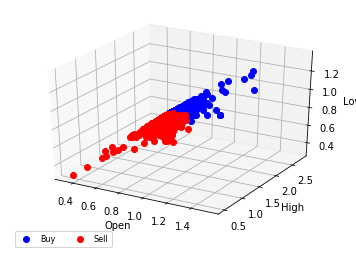

In [20]:
df_res = pd.DataFrame.from_csv("training_data/all_processed_data.csv")

x1 = df_res["Open_pc"].where(df_res["Close_pc"] > 1)
x1 = x1.dropna(axis=0, how='all')

y1 = df_res["High_pc"].where(df_res["Close_pc"] > 1)
y1 = y1.dropna(axis=0, how='all')

z1 = df_res["Low_pc"].where(df_res["Close_pc"] > 1)
z1 = z1.dropna(axis=0, how='all')

x0 = df_res["Open_pc"].where(df_res["Close_pc"] < 1)
x0 = x0.dropna(axis=0, how='all')

y0 = df_res["High_pc"].where(df_res["Close_pc"] < 1)
y0 = y0.dropna(axis=0, how='all')

z0 = df_res["Low_pc"].where(df_res["Close_pc"] < 1)
z0 = z0.dropna(axis=0, how='all')

colors=['b', 'r']

ax = plt.subplot(111, projection='3d')

ax.plot(x1, y1, z1, 'o', color=colors[0], label='Buy')
ax.plot(x0, y0, z0, 'o', color=colors[1], label='Sell')

ax.set_xlabel('Open')
ax.set_ylabel('High')
ax.set_zlabel('Low')

plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))
plt.savefig("figures/input.svg", format='svg', dpi=1200)
plt.show()

### Read all json in temp folder and append to result (used for multiprocessing)

In [21]:
if MULTIPROCESSOR == True:
    result = []

    directory = "temp_results/"
    for filename in os.listdir(directory):
        if filename.endswith(".json"): 
            js = open(directory+filename).read()
            temp_dict = json.loads(js)
            result.append(temp_dict)
        

### Print Results of the models

In [22]:
result_df = pd.DataFrame(result)
print(result_df)

     Adaboost Accuracy  Adaboost Fscore  BA_Adaboost  \
0             0.566123         0.540336     10819.24   
1             0.885266         0.847715     16960.51   
2             0.886473         0.851341     16657.76   
3             0.677536         0.641591     13386.15   
4             0.681159         0.637764     14010.03   
5             0.884964         0.849340     16466.70   
6             0.677536         0.641591     13386.15   
7             0.816727         0.773385     15652.32   
8             0.623792         0.600917     13027.33   
9             0.566123         0.540336     10819.24   
10            0.816727         0.773385     15652.32   
11            0.566123         0.540336     10819.24   
12            0.816727         0.773385     15652.32   
13            0.841184         0.792480     16455.14   
14            0.623792         0.600917     13027.33   
15            0.841184         0.792480     16455.14   
16            0.675725         0.646505     1392

### Add a column FinalValue per model.  Which takes taxes and commisions into account

In [23]:

## Go through each row
for index, row in result_df.iterrows():
    ## Initialize params
    benchmark = {'value':0,'loss':0,'gain':0,'transactions':len(TESTING_TICKERS)*2.0}
    decisiontree = {'value':0,'loss':0,'gain':0,'transactions':0}
    gaussiannb = {'value':0,'loss':0,'gain':0,'transactions':0}
    adaboost = {'value':0,'loss':0,'gain':0,'transactions':0}
    svc = {'value':0,'loss':0,'gain':0,'transactions':0}
    nn = {'value':0,'loss':0,'gain':0,'transactions':0}
    
    #models_dict = {'benchmark':benchmark,'DecisionTree':decisiontree,\
    #               'GaussianNB':gaussiannb,'Adaboost':adaboost, 'SVC':svc, 'NN':nn}
    ## No SVC model
    models_dict = {'benchmark':benchmark,'DecisionTree':decisiontree,\
                   'GaussianNB':gaussiannb,'Adaboost':adaboost, 'NN':nn}
    
    ## Gather each stock information
    for tick in TESTING_TICKERS:
        ## update each models
        for key, model in models_dict.items():
            stock_value = row[tick+"_"+key]
            if stock_value > MONEY:                         ## capital gain
                model['gain'] += stock_value-MONEY
            else:                                           ## loss
                model['loss'] += MONEY-stock_value
            
            if key != 'benchmark':
                model['transactions'] += row[tick+"_"+key+"_transactions"]
        
        
    ## Get Final Values
    for key, model in models_dict.items():
        ## more gains than loss
        if model['gain'] > model['loss']: 
            if key == 'benchmark':
                model['value'] = float(format(row['total_'+key] \
                                      - COMM_RATE*model['transactions'] \
                                      - GAIN_LONG*(model['gain']-model['loss']),'.2f'))
            else:
                model['value'] = float(format(row['total_'+key] \
                                      - COMM_RATE*model['transactions'] \
                                      - GAIN_SHORT*(model['gain']-model['loss']),'.2f'))
        ## more loss than gain
        else:    
            ## All model gains GAIN_LONG (assuming its on 25% tax bracket)
            model['value'] = float(format(row['total_'+key] - COMM_RATE*model['transactions'] \
                            + GAIN_LONG*(model['loss']-model['gain']),'.2f')) ## add tax credit
            

        result_df.set_value(index,key+"_FinalValue",model['value'])
    
    

In [24]:
print(result_df)
result_df.to_csv('Results.csv')  ## can use parameters: mode='a', header=False, if memory is an issue

     Adaboost Accuracy  Adaboost Fscore  BA_Adaboost  \
0             0.566123         0.540336     10819.24   
1             0.885266         0.847715     16960.51   
2             0.886473         0.851341     16657.76   
3             0.677536         0.641591     13386.15   
4             0.681159         0.637764     14010.03   
5             0.884964         0.849340     16466.70   
6             0.677536         0.641591     13386.15   
7             0.816727         0.773385     15652.32   
8             0.623792         0.600917     13027.33   
9             0.566123         0.540336     10819.24   
10            0.816727         0.773385     15652.32   
11            0.566123         0.540336     10819.24   
12            0.816727         0.773385     15652.32   
13            0.841184         0.792480     16455.14   
14            0.623792         0.600917     13027.33   
15            0.841184         0.792480     16455.14   
16            0.675725         0.646505     1392

### Graph entire results.  All 480 models

In [25]:
def graph_all_models(df,model_name,title,filename):
    y = df[model_name].values
    fnc = lambda i,j,k: str(i)+'_'+str(j)+'_'+str(k)
    x_ticks = list(map(fnc,df['target_ratio'],df['sell_below'],df['buy_above']))
    x = np.arange(len(x_ticks))

    graph_data = zip(x_ticks,y)
    graph_data = sorted(graph_data)   ## sort labels

    y = [ y for x, y in graph_data ]
    x_ticks = [ x for x, y in graph_data ]

    fig, ax = plt.subplots()
    opacity = 0.5
    plt.bar(x,y,align='center',alpha=opacity)
    plt.xticks(x,x_ticks,rotation=90,)
    plt.ylabel('Final Value')
    plt.title(title)
    plt.tick_params(axis='x',which='major',labelsize=3)
    plt.show()
    fig.savefig("figures/"+filename, format='svg', dpi=1200)
    
df_res = pd.DataFrame.from_csv("Results.csv")


### Graph of NN Models

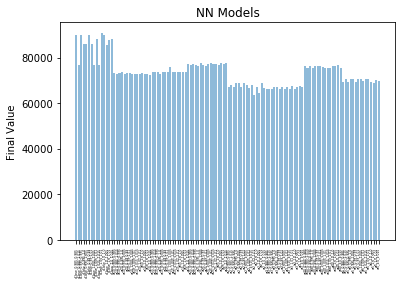

In [26]:
graph_all_models(df = df_res, \
                model_name = 'NN_FinalValue', \
                title = 'NN Models', \
                filename = 'NN_models.svg')

### Graph of Decision Tree Models

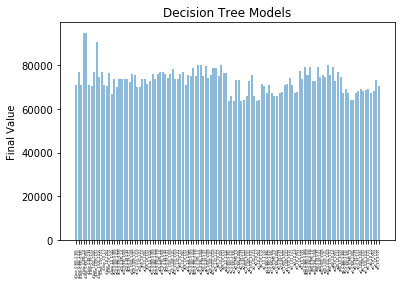

In [27]:
graph_all_models(df = df_res, \
                model_name = 'DecisionTree_FinalValue', \
                title = 'Decision Tree Models', \
                filename = 'DT_models.svg')

### Graph of Adaboost Models

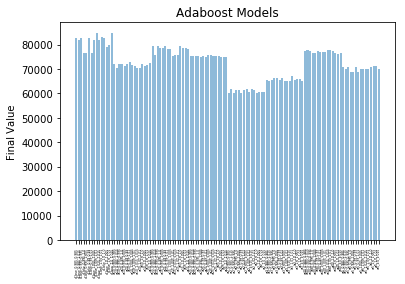

In [28]:
graph_all_models(df = df_res, \
                model_name = 'Adaboost_FinalValue', \
                title = 'Adaboost Models', \
                filename = 'Adaboost_models.svg')

### Graph of GaussianNB Models

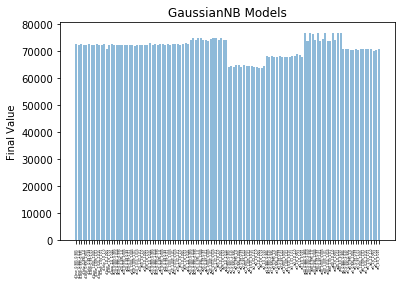

In [29]:
graph_all_models(df = df_res, \
                model_name = 'GaussianNB_FinalValue', \
                title = 'GaussianNB Models', \
                filename = 'GaussianNB_models.svg')

### Get the top performing model of each model

In [30]:
max_benchmark_FinalValue = result_df['benchmark_FinalValue'].iloc[0]
max_NN_FinalValue = 0
max_GaussianNB_FinalValue = 0
max_Adaboost_FinalValue = 0
max_DecisionTree_FinalValue = 0
max_SVC_FinalValue = 0

row_benchmark = result_df.iloc[0]
row_NN = None
row_GaussianNB = None
row_Adaboost = None
row_DecisionTree = None
row_SVC = None

for index, row in result_df.iterrows():
    if row['NN_FinalValue'] > max_NN_FinalValue:
        row_NN = copy.deepcopy(row)
        max_NN_FinalValue = row['NN_FinalValue']
        
    if row['GaussianNB_FinalValue'] > max_GaussianNB_FinalValue:
        row_GaussianNB = copy.deepcopy(row)
        max_GaussianNB_FinalValue = row['GaussianNB_FinalValue']
        
    if row['Adaboost_FinalValue'] > max_Adaboost_FinalValue:
        row_Adaboost = copy.deepcopy(row)
        max_Adaboost_FinalValue = row['Adaboost_FinalValue']
        
    if row['DecisionTree_FinalValue'] > max_DecisionTree_FinalValue:
        row_DecisionTree = copy.deepcopy(row)
        max_DecisionTree_FinalValue = row['DecisionTree_FinalValue']
        
    #if row['SVC_FinalValue'] > max_SVC_FinalValue:
    #    row_SVC = copy.deepcopy(row)
    #    max_SVC_FinalValue = row['SVC_FinalValue']

print("benchmark FinalValue: {}".format(max_benchmark_FinalValue))
print("Max NN FinalValue: {}".format(max_NN_FinalValue))
print("Max GaussianNB FinalValue: {}".format(max_GaussianNB_FinalValue))
print("Max Adaboost FinalValue: {}".format(max_Adaboost_FinalValue))
print("Max DecisionTree FinalValue: {}".format(max_DecisionTree_FinalValue))
#print("Max SVC FinalValue: {}".format(max_SVC_FinalValue))



benchmark FinalValue: 74853.0
Max NN FinalValue: 90873.81
Max GaussianNB FinalValue: 76818.63
Max Adaboost FinalValue: 84835.81
Max DecisionTree FinalValue: 94896.15


### Get summary of the top models

In [31]:
#model_list = [('benchmark',row_benchmark),('NN',row_NN),('GaussianNB',row_GaussianNB),\
#               ('SVC',row_SVC),('Adaboost',row_Adaboost),('DecisionTree',row_DecisionTree)]
## No SVC
model_list = [('benchmark',row_benchmark),('NN',row_NN),('GaussianNB',row_GaussianNB),\
               ('Adaboost',row_Adaboost),('DecisionTree',row_DecisionTree)]

best_model = None
best_model_val = 0

for name, model in model_list:
    ## Get all data relevant to each model
    for index_name in model.index:
        if name not in index_name and index_name not in ["sell_below","buy_above","target_ratio"]:
        #if name not in index_name:
            del model[index_name]

    print("\n{} Data: \n{}".format(name,model))
    
    if model[name+"_FinalValue"] > best_model_val:
        best_model_val = model[name+"_FinalValue"]
        best_model = name + "_" + model["target_ratio"] + "_" + str(model["sell_below"]) \
                          + "_" + str(model["buy_above"])



benchmark Data: 
BA_benchmark            18139.2
CHK_benchmark            9749.5
CMG_benchmark           8140.79
FCEL_benchmark          2896.68
HON_benchmark           11879.7
MA_benchmark            13322.6
SD_benchmark            8545.85
TPLM_benchmark          1363.63
buy_above                  0.99
sell_below                 0.99
target_ratio                vr2
total_benchmark         74037.9
benchmark_FinalValue      74853
Name: 0, dtype: object

NN Data: 
BA_NN                       10000
BA_NN_transactions              0
CHK_NN                      10000
CHK_NN_transactions             0
CMG_NN                      10000
CMG_NN_transactions             0
FCEL_NN                   9465.17
FCEL_NN_transactions           10
HON_NN                      10000
HON_NN_transactions             0
MA_NN                       10000
MA_NN_transactions              0
NN Accuracy              0.524155
NN Fscore                0.315765
SD_NN                       10000
SD_NN_transactions    

### Graph model's score

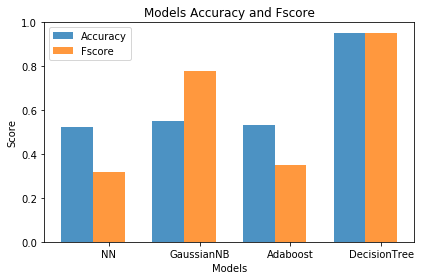

In [32]:
accuracies = []
fscores = []
names = []

for name, model in model_list:
    if name != "benchmark":
        accuracies.append(model[name+" Accuracy"])
        fscores.append(model[name+" Fscore"])
        names.append(name)


n_groups = len(model_list) - 1 ## subtract benchmark


## create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35                         
opacity = 0.8

# Bar features
rects1 = plt.bar(index, accuracies, bar_width,alpha=opacity,label="Accuracy")  
rects2 = plt.bar(index+bar_width, fscores, bar_width,alpha=opacity,label="Fscore") 

## Labels
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Models Accuracy and Fscore')
plt.xticks(index + bar_width, names)
plt.legend()
 
plt.tight_layout()
plt.show()
fig.savefig("figures/Scores.svg", format='svg', dpi=1200)

### Graph each stocks performance of the best optimal model

In [33]:
print(best_model)

DecisionTree_vClose_0.995_1.005


In [34]:
graph_data = []

## Get test data that used best model
filelist = glob.glob("model_predictions/*")
for f in filelist:
    if best_model+".csv" in f:
        graph_data.append(f)
            
print(graph_data)

['model_predictions/BA_DecisionTree_vClose_0.995_1.005.csv', 'model_predictions/CHK_DecisionTree_vClose_0.995_1.005.csv', 'model_predictions/CMG_DecisionTree_vClose_0.995_1.005.csv', 'model_predictions/FCEL_DecisionTree_vClose_0.995_1.005.csv', 'model_predictions/HON_DecisionTree_vClose_0.995_1.005.csv', 'model_predictions/MA_DecisionTree_vClose_0.995_1.005.csv', 'model_predictions/SD_DecisionTree_vClose_0.995_1.005.csv', 'model_predictions/TPLM_DecisionTree_vClose_0.995_1.005.csv']


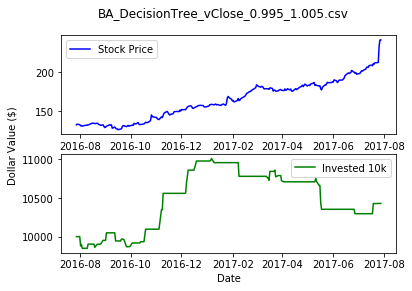

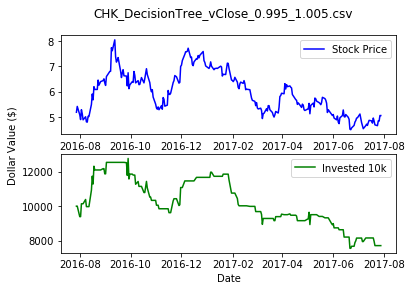

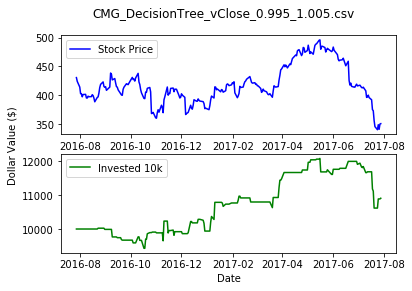

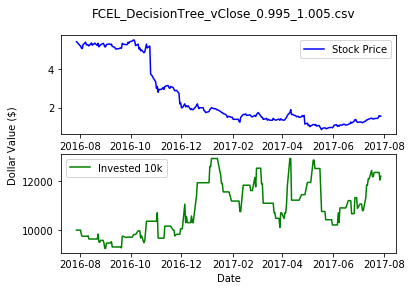

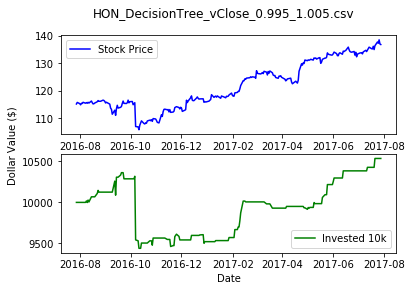

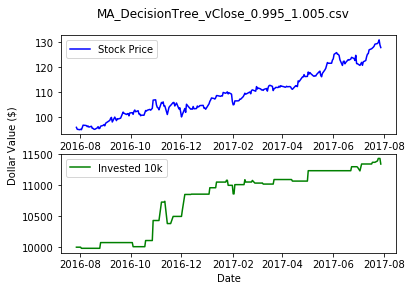

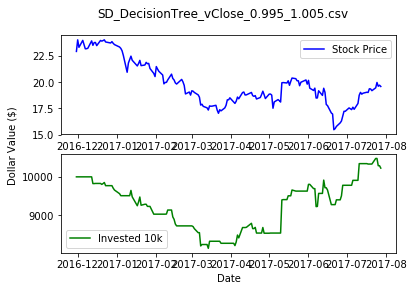

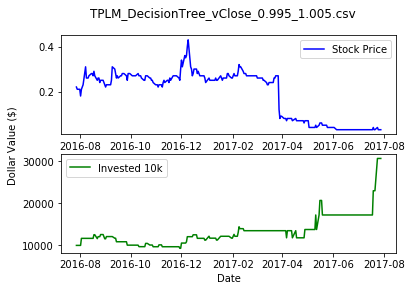

In [35]:
def plot_data(f,df):
    remove = len("model_predictions/")
    file = f[remove:]
    tick = file.split('_')[0]
    
    fig = plt.figure()
    ## Top plot
    df0 = pd.DataFrame.from_csv("testing_data/"+tick+"_processed.csv")
    price = df0['vClose']
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(price.index,price,label='Stock Price',color='b')
    ax1.legend()

    ## Bottom plot
    money = df['Money']
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(money.index,money,label='Invested 10k',color='g')
    ax2.set_xlabel('Date')
    ax2.legend()

    fig.text(0.00, 0.5, 'Dollar Value ($)', va='center', rotation='vertical')
    
    plt.suptitle(file)
    plt.show()
    #fig.savefig("figures/"+file+'.png')
    fig.savefig("figures/"+file+'.svg', format='svg', dpi=1200)
    plt.close(fig)


for f in graph_data:
    df = pd.DataFrame.from_csv(f)
    
    plot_data(f,df)
    
    

### Helper function for create bar graph

In [36]:
def bar_graph(graph_data,number_of_groups, filename, xlabel, title, xticks):
    n_groups = number_of_groups

    ## create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.167   ## each bar need 100%.  There are 5 models plus the space, so divide by 6
    opacity = 0.8

    # Bar features
    rects = {}
    pos = 0
    for k, v in graph_data.items():
        ## pos moves the bar through x-axis
        rects[k] = plt.bar(index+pos, v, bar_width,alpha=opacity,label=k)    
        pos += bar_width

    ## Labels
    plt.xlabel(xlabel)
    plt.ylabel('Value')
    plt.title(title)
    plt.xticks(index + bar_width, xticks)
    plt.legend()

    plt.tight_layout()
    plt.show()
    fig.savefig("figures/"+filename+".svg", format='svg', dpi=1200)

### Gather data of each stock for each optimal models

In [37]:
graph_data = {}

for name, model in model_list:
    graph_data[name] = []

for tick in TESTING_TICKERS:                              
    for name, model in model_list:
        for index_name in model.index:
            ## Get data about that ticker
            if tick in index_name and 'transactions' not in index_name:    
                graph_data[name].append(model[index_name])
                

print(graph_data)

{'Adaboost': [10000.0, 10000.0, 10000.0, 13422.42, 9588.21, 14118.17, 9833.75, 10000.0], 'DecisionTree': [10429.16, 10535.67, 11337.28, 30580.95, 10228.7, 12195.04, 7711.18, 10909.16], 'NN': [10000.0, 10000.0, 10000.0, 25402.84, 10000.0, 9465.17, 10000.0, 10000.0], 'benchmark': [18139.209999999999, 11879.66, 13322.559999999999, 1363.6300000000001, 8545.8500000000004, 2896.6799999999998, 9749.5, 8140.79], 'GaussianNB': [16577.61, 10430.84, 10216.47, 2934.24, 8904.41, 9371.85, 10001.8, 8169.4]}


### Graph Models

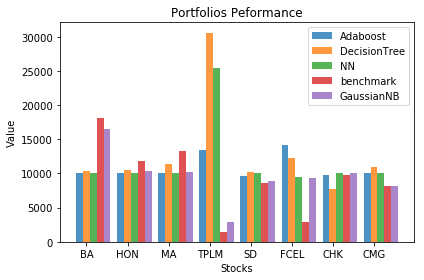

In [38]:
bar_graph(graph_data = graph_data, \
          number_of_groups = len(TESTING_TICKERS),\
          filename = 'Portfolio',\
          xlabel = 'Stocks', \
          title = 'Portfolios Peformance',\
          xticks = TESTING_TICKERS)

### Gather data of each optimal models

In [39]:
graph_data = {}

for name, model in model_list:
    graph_data[name] = []

tick = 'FinalValue'                              
for name, model in model_list:
    for index_name in model.index:
        ## Get data about that ticker
        if tick in index_name and 'transactions' not in index_name:    
            graph_data[name].append(model[index_name])
        
print(graph_data)

{'Adaboost': [84835.81], 'DecisionTree': [94896.15], 'NN': [90873.81], 'benchmark': [74853.0], 'GaussianNB': [76818.63]}


### Graph Total Final Value of the optimal models

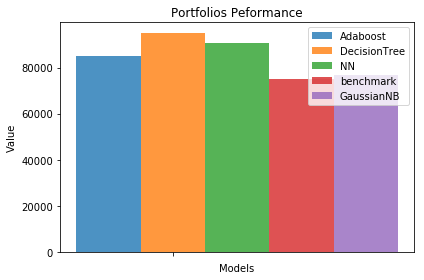

In [40]:
bar_graph(graph_data = graph_data, \
          number_of_groups = 1,\
          filename = 'Portfolios_Total',\
          xlabel = 'Models',\
          title = 'Portfolios Peformance',\
          xticks = "")